<a href="https://colab.research.google.com/github/mdaugherity/MachineLearning2024/blob/main/tutorial/Tutorial_14_Linear_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dr. Daugherity, Abilene Christian University, PHYS 453**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Common Utilities
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.inspection import DecisionBoundaryDisplay

# Classifiers
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

# Tutorial 14: Linear Models
It is helpful to run a linear classifier or two because they are fast and easy while giving a good baseline to compare with more complex models.  

Be warned, there are lots and lots of choices, and many have confusing names.  I'm here to give you a quick sample of reasonable choices.

**REFERENCES**
* User Guide: https://scikit-learn.org/stable/modules/linear_model.html


# Regularization
A linear fit finds the weights $w$ so that $Xw$ is the best approximation of $y$. Ordinary Least Squares does this by minimizing the total error (sum of the differences between fit and actual squared):

$\min_{w} || X w - y||_2^2$

Regularization is adding a penalty based on the size of the weights.

## L2 Regularization
We typically calculate the "length" of the weight vector using Pythagoras.  The L2 regularization term is simply a constant times the sum of each weight squared:

$\min_{w} || X w - y||_2^2 + \alpha ||w||_2^2$

This keeps any single weight from getting too big to improve stability and limit overfitting.

## L1 Regularization
We could instead add the absolute value of each weight:

$\min_{w} || X w - y||_2^2 + \alpha ||w||_1$

Here the goal is to eliminate features by driving a weight down to zero.  



# Regression (Fitting) Models

These models are essentially fancier version of ordinary least-squares fits with regularization.  LogisticRegression, which is actually a classifier, fits the S-shaped logistic function instead of a straight line.  

| Classifier | Regularization |
|---|---|
| Ridge | L2 |
| Lasso | L1 |
| ElasticNet| Both |
| LogisticRegression| Both |

Each of these also has a version with built-in cross-validation to quickly find $\alpha$: RidgeCV, LassoCV, etc.


## Silly 1D Example

In [2]:
X, y = datasets.make_blobs(n_samples=50, centers=2, cluster_std=0.5, n_features=1, random_state=0)

clf = RidgeClassifier(alpha=0)
clf.fit(X,y)
print('Fit coef:',clf.coef_)
print('Fit int :',clf.intercept_)

Fit coef: [0.57757773]
Fit int : [-1.54997638]


For many regression models (but not all) $y$ is transformed from [0,1] to [-1,+1] so the prediction is simply based on the sign of $Xw$.  This example shows some 1D data with a linear fit and predictions.

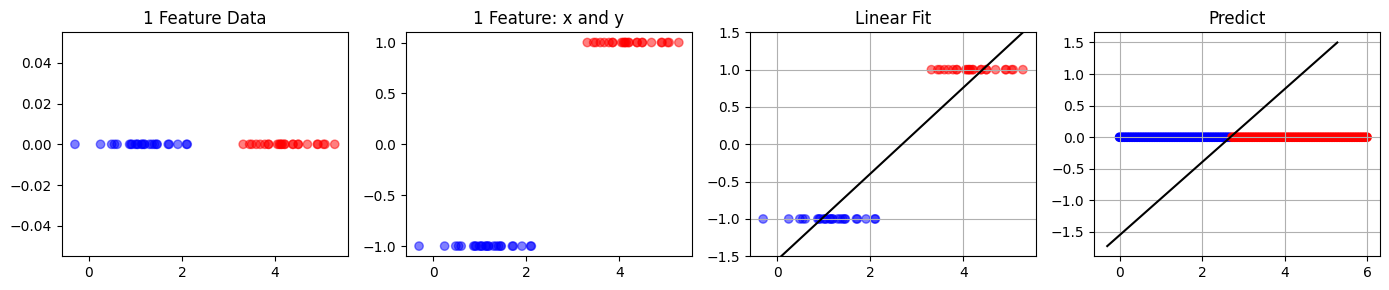

In [3]:
plt.figure(figsize=(14,3))

plt.subplot(1,4,1)
plt.scatter(X, np.zeros_like(X), c=y,alpha=0.5, cmap='bwr')
plt.title('1 Feature Data')

plt.subplot(1,4,2)
yt = 2*y-1  # transform from 0,1 to -1,+1
plt.scatter(X, yt, c=y,alpha=0.5, cmap='bwr')
plt.title('1 Feature: x and y')

plt.subplot(1,4,3)
X_fit = np.linspace(X.min(), X.max(), num=2)
y_fit = X_fit*clf.coef_+ clf.intercept_
plt.scatter(X, yt, c=y,alpha=0.5, cmap='bwr')
plt.plot(X_fit, y_fit, 'k-')
plt.ylim(-1.5, 1.5)
plt.grid()
plt.title('Linear Fit')

plt.subplot(1,4,4)
X_pred = np.linspace(0,6, num=100).reshape(-1,1)
y_pred = clf.predict(X_pred)
plt.scatter(X_pred, 0*y_pred, c=y_pred, cmap='bwr')
plt.plot(X_fit, y_fit, 'k-')
plt.grid()
plt.title('Predict')

plt.tight_layout()
plt.show()

Similar but with logistic fit

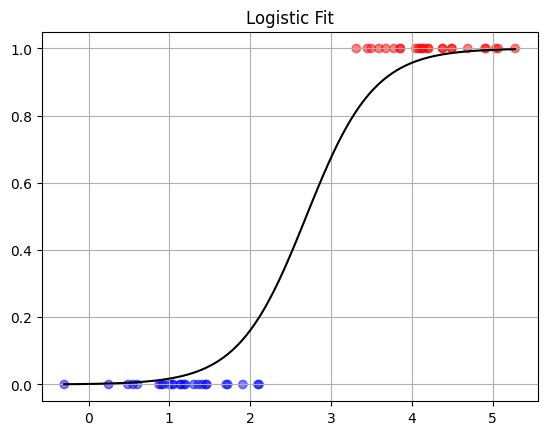

In [4]:
clf = LogisticRegression()
clf.fit(X, y)
X_fit = np.linspace(X.min(), X.max(), num=100)
ylog = 1.0 / (1 + np.exp(-((clf.coef_*X_fit).ravel()+clf.intercept_)))
plt.plot(X_fit,ylog,'k-')
plt.scatter(X, y, c=y,alpha=0.5, cmap='bwr')
plt.grid()
plt.title('Logistic Fit')
plt.show()

## Feature Importance With Slopes
The weights can give you a feel for feature importance, but keep in mind:
* you have to scale the data first
* this will miss non-linear correlations  

In [5]:
iris_bunch = datasets.load_iris()
X_iris = iris_bunch.data
y_iris = iris_bunch.target
X = X_iris[y_iris!=2] # drop species 2
y = y_iris[y_iris!=2]
print(X.shape)

(100, 4)


In [6]:
Xrand = np.random.random_sample(100)
X2 = np.c_[X,Xrand]
print(X2.shape)
X2_features = iris_bunch.feature_names + ['Random Noise']

(100, 5)


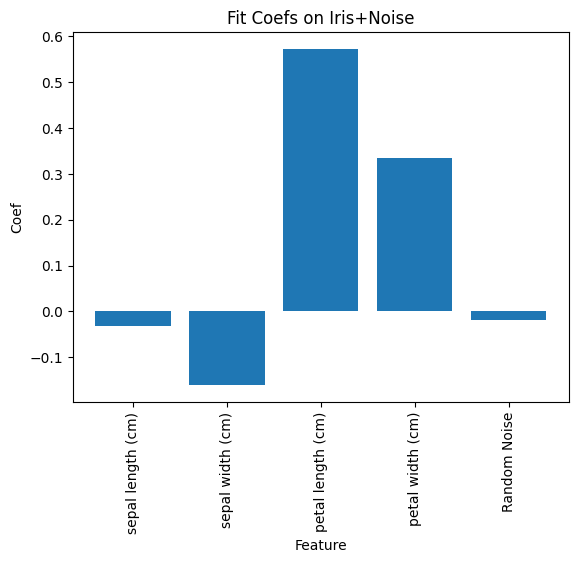

In [7]:
scaler = StandardScaler()
scaler.fit(X2)
X2scaled = scaler.transform(X2)
clf = RidgeClassifier(alpha=0)
clf.fit(X2scaled, y)

plt.bar(np.arange(5), clf.coef_)
plt.xlabel('Feature')
plt.ylabel('Coef')
plt.xticks(ticks=np.arange(5), labels=X2_features, rotation=90)
plt.title('Fit Coefs on Iris+Noise')
plt.show()

## Feature Importance with L1 Regularization  

Recall that L1 regularization with enough $\alpha$ will drive weights for the "less important" features down to zero

In [8]:
lasso = LassoCV()
lasso.fit(X2scaled,y)
print('Alpha from CV search: ',lasso.alpha_)
print('Fit Coef: ',lasso.coef_)


Alpha from CV search:  0.004849951157431744
Fit Coef:  [-0.         -0.08469996  0.26637125  0.16629594 -0.00536728]


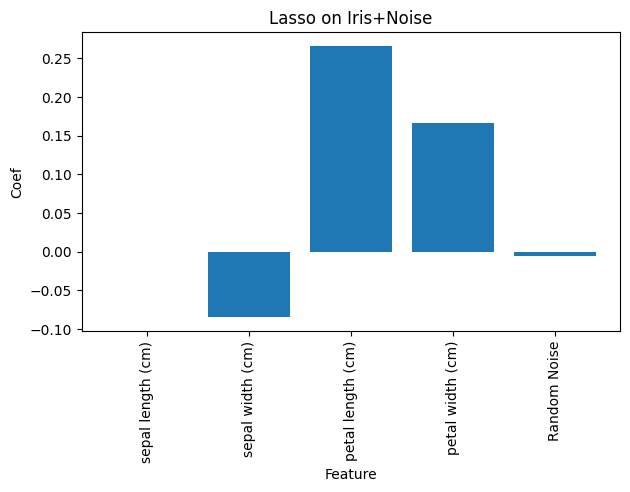

In [9]:
plt.bar(np.arange(5), lasso.coef_)
plt.xlabel('Feature')
plt.ylabel('Coef')
plt.xticks(ticks=np.arange(5), labels=X2_features, rotation=90)
plt.tight_layout()
plt.title('Lasso on Iris+Noise')
plt.show()

# Support Vector Machines
* User's Guide - http://scikit-learn.org/stable/modules/svm.html
* API - http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

SVC is the support vector classifier, but there are other classes for a linearsvc and "Nu"svc.  The training points closest to the boundary are called the **support vectors** and these are used specially to adjust the margins.  SVC training minimizes weight vector plus a constant C times margin errors.  Has the ability to use non-linear **kernels** to make decision boundaries that aren't just straight lines!


To really see what kernels can do, let's try some circles

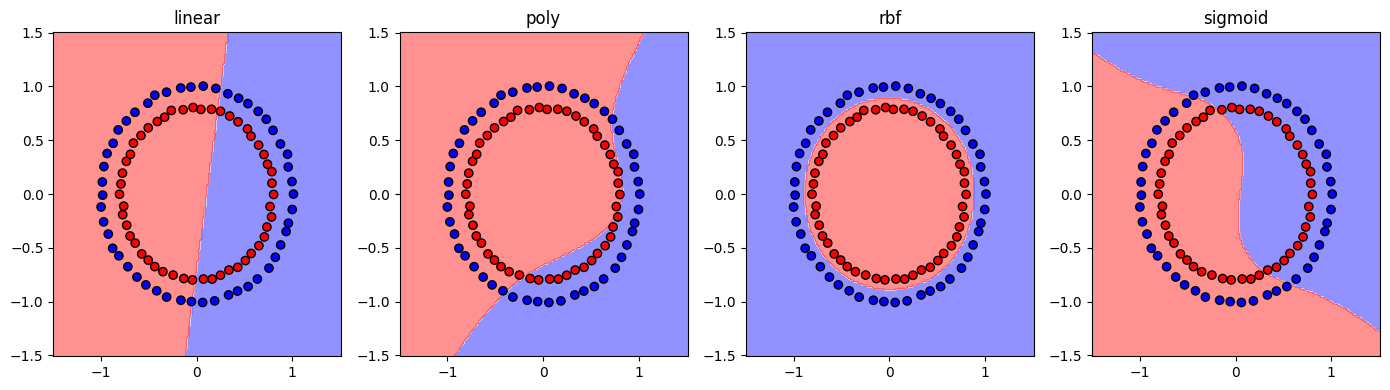

In [10]:
X,y = datasets.make_circles(noise=0.01)

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
NUM = len(kernels)

plt.figure(figsize=(14,4))
for i in range(NUM):
  kernel = kernels[i]
  ax = plt.subplot(1,NUM,i+1)
  clf = SVC(kernel=kernel)
  clf.fit(X,y)
  cm = 'bwr'
  DecisionBoundaryDisplay.from_estimator(clf,X,grid_resolution=200,ax=ax,alpha=0.5,cmap=cm,eps=0.5,response_method='predict')  # eps zooms out
  plt.scatter(X[:,0], X[:,1], c=y, edgecolors='k',cmap=cm)
  plt.title(kernel)

plt.tight_layout()
plt.show()

The **Support Vectors** are the points close to the boundary.  The definition of "close" depends on the regularization parameter C.  This example shows varying C and marking the support vectors.  

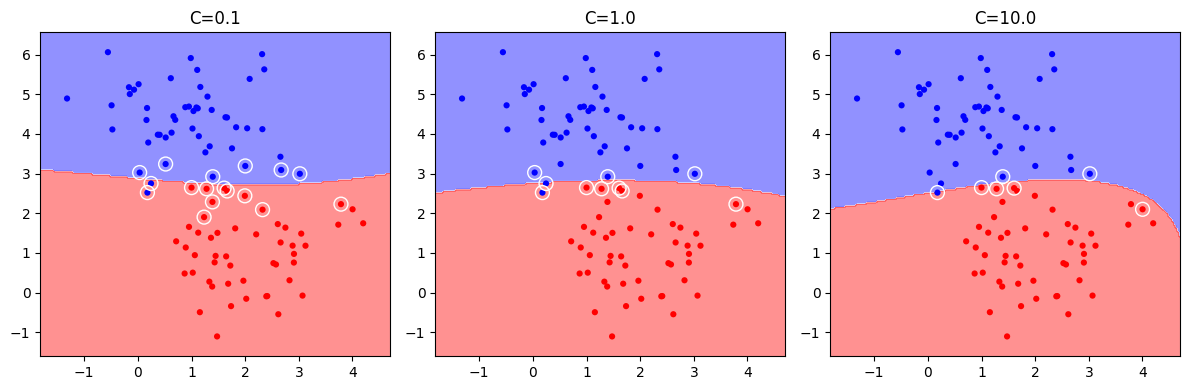

In [11]:
X,y = datasets.make_blobs(n_samples=100, centers=2, cluster_std=0.9, n_features=2, random_state=0)
NUM = 3
plt.figure(figsize=(12,4))
CLIST = np.logspace(-1,1,NUM)
for i in range(NUM):
  ax = plt.subplot(1,NUM,i+1)
  C = CLIST[i]
  clf = SVC(C=C, kernel='poly')
  clf.fit(X,y)
  cm = 'bwr'
  DecisionBoundaryDisplay.from_estimator(clf,X,grid_resolution=200,ax=ax,alpha=0.5,cmap=cm,eps=0.5,response_method='predict')  # eps zooms out
  plt.scatter(X[:,0], X[:,1], c=y, edgecolors='none',cmap=cm, s=20)
  plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], facecolors='none',edgecolors='w',s=100)
  plt.title(f'C={C}')

plt.tight_layout()
plt.show()

# Search Models - SGD

Once again we get a poorly-named classifier.  The term Stochastic Gradient Descent is simply an optimization technique of minimizing a function by taking downhill steps from a starting point until you find a local minimum or give up.This is also the basis for **neural networks**.
The SGDClassifier is a **linear** model with support for L1 and L2regularization that uses gradient descent to fit.

The SGDClassifier is efficient for huge datasets.
There are many loss functions including the historically important Perceptron. Training occurs by updating the weights for each training point (instead of working in batches), so it requires minimal memory and takes each step very quickly. The downside as we shall see in neural networks is training can be very finicky.  The outcome is **hugely dependent on random numbers**, and there are many options for controlling the search.

* User's Guide - http://scikit-learn.org/stable/modules/sgd.html
* API - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

The default loss function is 'hinge' which is equivalent to a linear SVM.  There is a good summary here: https://scikit-learn.org/stable/auto_examples/linear_model/plot_sgd_loss_functions.html



Attempt  0
Numer of iterations:  15
Fit Coef:  [[ 15.7248591  -41.35559396]]

Attempt  1
Numer of iterations:  8
Fit Coef:  [[ -1.87727245 -28.25968785]]

Attempt  2
Numer of iterations:  7
Fit Coef:  [[ 24.1954228  -46.97332149]]

Attempt  3
Numer of iterations:  23
Fit Coef:  [[ 13.90587612 -26.68198705]]


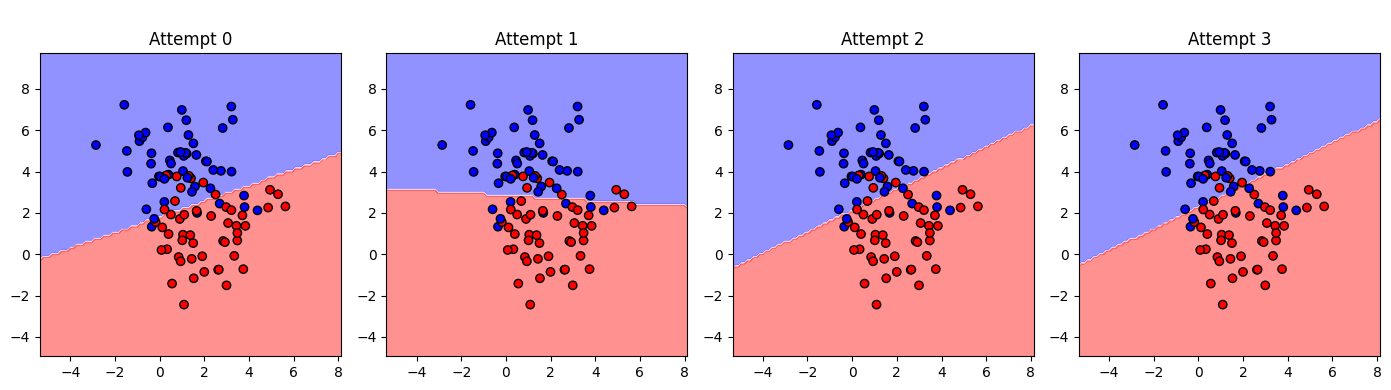

In [12]:
X,y = datasets.make_blobs(n_samples=100, centers=2, cluster_std=1.5, n_features=2, random_state=0)
NUM = 4
plt.figure(figsize=(14,NUM))
for i in range(NUM):
  ax = plt.subplot(1,NUM,i+1)
  clf = SGDClassifier(loss='hinge')
  clf.fit(X,y)
  cm = 'bwr'
  DecisionBoundaryDisplay.from_estimator(clf,X,grid_resolution=100,ax=ax,alpha=0.5,cmap=cm,eps=2.5,response_method='predict')  # eps zooms out
  plt.scatter(X[:,0], X[:,1], c=y, edgecolors='k',cmap=cm)
  plt.title(f'\nAttempt {i}')
  print('\nAttempt ',i)
  print('Numer of iterations: ', clf.n_iter_)
  print('Fit Coef: ', clf.coef_)

plt.tight_layout()
plt.show()

# Recipes

In [13]:
# These functions visualize results from a parameter grid search.

def make_grid_plot_labels(grid_clf):
  # Turns a parameter dictionary entry into a single string and returns the whole list
  res = grid_clf.cv_results_
  NUM_KEYS = len(res['params'][0].values())
  labels = []
  for item in res['params']:
    labels.append("_".join( [str(val) for val in item.values()]))
  return labels

def make_grid_plot(grid_clf):
  # Displays the scores for every set of parameters
  res = grid_clf.cv_results_
  plt.figure(figsize=(8,4))
  plt.axvline(grid_clf.best_index_, color='black', lw=2) # draw black line behind best params

  NUM_KEYS = len(res['params'])
  x = np.arange(NUM_KEYS)
  plt.plot(res['mean_test_score'],'-o', label='Val')
  plt.fill_between(x,res['mean_test_score']+res['std_test_score'], res['mean_test_score']-res['std_test_score'], alpha=0.2)
  #plt.errorbar(x, res['mean_test_score'],yerr=res['std_test_score'],xerr=0,fmt='-o', capsize=2, label='Val')

  plt.plot(res['mean_train_score'],'-s', label='Train')
  plt.fill_between(x,res['mean_train_score']+res['std_train_score'], res['mean_train_score']-res['std_train_score'], alpha=0.2)
  #plt.errorbar(x, res['mean_train_score'],yerr=res['std_train_score'],xerr=0,fmt='-s', capsize=2,label='Train')
  plt.title('Grid CV Results')
  plt.ylabel('Mean Test Score')

  labels = make_grid_plot_labels(grid_clf)
  plt.xticks(ticks = x, labels=labels, rotation=90)
  plt.legend()
  plt.grid()
  plt.show()

In [14]:
X = X_iris
y = y_iris
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2,stratify=y)

## Linear - Ridge
It is helpful to run a linear classifier or two because they are fast and easy while giving a good baseline to compare with more complex models.  

Note that there is a RidgeClassifierCV which will do the grid search automatically.  Here I'm choosing to do the grid search myself for consistency with the other classifiers.

**References**
* User Guide: https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression-and-classification
* API: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
* API: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html


**Parameters to know**
* ```alpha```: (default=1.0) regularization parameter (larger values give more regularization)  

**Training Notes**
* We use linear models because they are fast and easy to train.  A small log search on alpha is normally sufficient.  


Grid Parameters: {'clf__alpha': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])}
Best parameters: {'clf__alpha': 0.01}
Best Validation Score:	0.858


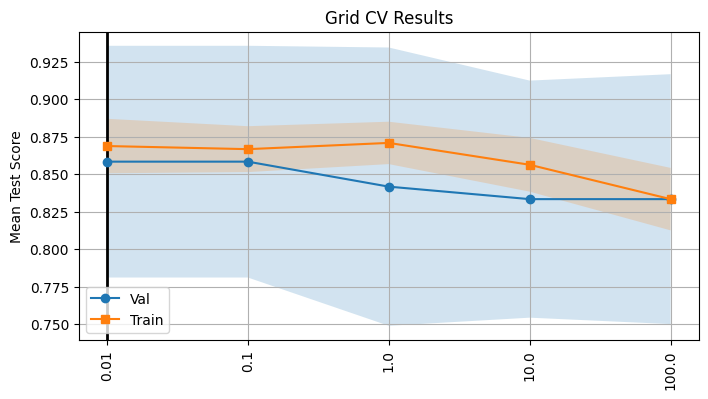

In [15]:
# Define Pipeline
estimators = [('scaler', StandardScaler()), ('clf', RidgeClassifier()) ]
pipe = Pipeline(estimators)

# Grid Search Parameters
ALPHAS = np.logspace(-2,2,5)
params = {'clf__alpha':ALPHAS}
print('Grid Parameters:',params)

grid_clf = GridSearchCV(pipe, param_grid=params, return_train_score=True)
grid_clf.fit(X_train, y_train)

print('Best parameters:', grid_clf.best_params_)
print(f"Best Validation Score:\t{grid_clf.best_score_:0.3f}")

make_grid_plot(grid_clf)

##Support Vector Machines

Works by ignoring every data point except those near the boundary (aka the 'support vectors') and tries to maximize the distance.  Can use the kernel trick to add non-linear features to a linear classifier.

**References**
* User Guide: https://scikit-learn.org/stable/modules/svm.html
* API: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

**Parameters to know**
* ```kernel```: Default is 'rbf', options are ['linear', 'poly', 'rbf', 'sigmoid'].  
* ```degree```=3, only used for poly kernel
* ```C```=1.0, L2 regularization parameter, C is inverse of alpha so larger values give less regularization

**Training Notes**
* If the dataset is very large consider switching to LinearSVC for faster performance

Grid Parameters: {'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
Best parameters: {'clf__kernel': 'linear'}
Best Validation Score:	0.967


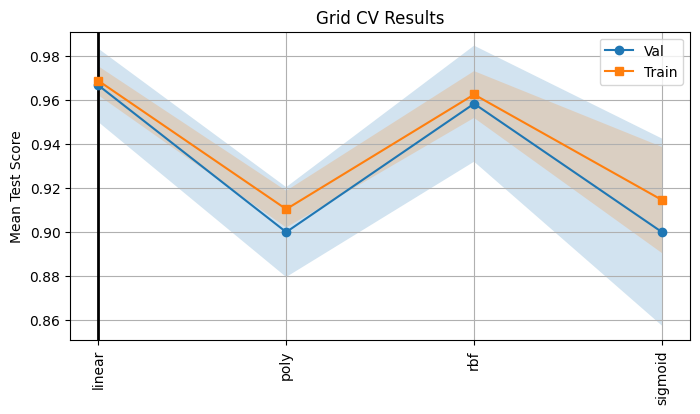

In [16]:
# Define Pipeline
estimators = [('scaler', StandardScaler()), ('clf', SVC()) ]
pipe = Pipeline(estimators)

# Grid Search Parameters
params = {'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'] }
print('Grid Parameters:',params)

grid_clf = GridSearchCV(pipe, param_grid=params, return_train_score=True)
grid_clf.fit(X_train, y_train)

print('Best parameters:', grid_clf.best_params_)
print(f"Best Validation Score:\t{grid_clf.best_score_:0.3f}")

make_grid_plot(grid_clf) # Plot the results

## Stochastic Gradient Descent
It is helpful to run a linear classifier or two because they are fast and easy while giving a good baseline to compare with more complex models.  

**References**
* User Guide: https://scikit-learn.org/stable/modules/sgd.html#sgd
* API: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier

**Parameters to know**
* ```loss```: (default='hinge') options include: 'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron'

**Training Notes**
* Be wary that your answer can depend hugely on random values.  There are lots of options for controlling the search I'm not listing here.

Grid Parameters: {'clf__loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron']}
Best parameters: {'clf__loss': 'hinge'}
Best Validation Score:	0.950


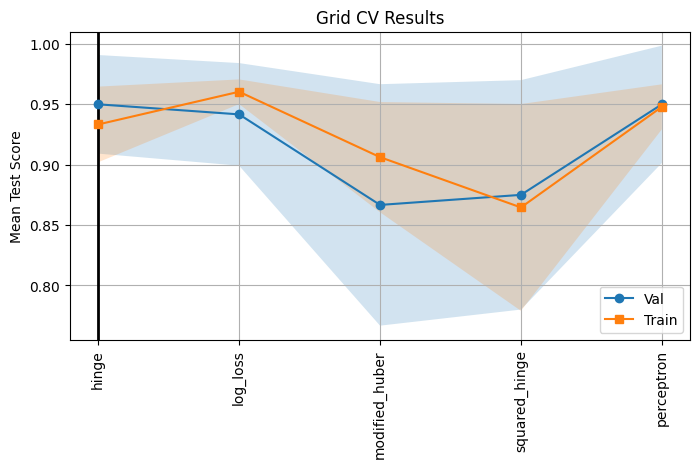

In [17]:
# Define Pipeline
estimators = [('scaler', StandardScaler()), ('clf', SGDClassifier(random_state=0)) ]
pipe = Pipeline(estimators)

# Grid Search Parameters
loss_funs = ['hinge', 'log_loss', 'modified_huber','squared_hinge','perceptron']
params = {'clf__loss':loss_funs}
print('Grid Parameters:',params)

grid_clf = GridSearchCV(pipe, param_grid=params, return_train_score=True)
grid_clf.fit(X_train, y_train)

print('Best parameters:', grid_clf.best_params_)
print(f"Best Validation Score:\t{grid_clf.best_score_:0.3f}")

make_grid_plot(grid_clf)